# Regression with a Flood Prediction Dataset

## corelacao de pearson

# pip install
##   tensorflow,
##  numpy
##   scikeras
##   seaborn
##   pandas
##   matplotlib
##   sklearn
##   


In [57]:
import pandas as pd 
import seaborn as sns
import numpy as np
import torch
import cv2
import keras_core as keras
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import scikeras
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
import os
import csv
import shutil
from PIL import Image
import matplotlib

verbose = 0

salvando validacao treino e teste

In [128]:
df = pd.read_csv(r"C:\Users\CaioM\edital109-arthur\digise\Data_Entry_2017_v2020.csv")
df['Finding Labels'] = df['Finding Labels'].apply(lambda x: x.split('|'))
#df.drop('Image Index', inplace=True, axis= 1)
mlb = MultiLabelBinarizer()
one_hot_encoded = mlb.fit_transform(df['Finding Labels'])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=mlb.classes_)
df_final = pd.concat([df.drop('Finding Labels', axis=1), one_hot_df], axis=1)
df_dum = pd.get_dummies(df_final['Patient Gender'])
df_final = pd.concat([df_final.drop('Patient Gender', axis=1), df_dum], axis=1)
df_dum2 = pd.get_dummies(df_final['View Position'])
df_final = pd.concat([df_final.drop('View Position', axis=1), df_dum2], axis=1)
df_final = df_final.drop('Follow-up #',axis=1)
pd.set_option('display.max_columns', None)


df_final['Image Index'] = df_final['Image Index'].str.replace('.png', '', regex=False)
df_final = df_final.drop(["Image Index","Patient ID","OriginalImage[Width","Height]","OriginalImagePixelSpacing[x","y]"],axis=1)
df_final = np.array(df_final)

In [129]:
df_final.shape

(112120, 20)

## Dividir as imagens em pastas diferentes (somente se tiver mais de 70 mil imagens)

In [24]:
# import os
# import shutil

# def dividir_imagens(pasta_origem, pasta_destino):
#     # Verifica se a pasta de destino existe, se não, cria-a
#     if not os.path.exists(pasta_destino):
#         os.makedirs(pasta_destino)

#     # Lista todos os arquivos da pasta de origem
#     arquivos = [f for f in os.listdir(pasta_origem) if os.path.isfile(os.path.join(pasta_origem, f))]

#     # Filtra apenas as imagens (jpeg, jpg, png, etc.)
#     imagens = [f for f in sorted(arquivos) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff'))]

#     # Calcula a metade da lista de imagens
#     metade = len(imagens) // 2

#     # Move a metade das imagens (de cima para baixo) para a pasta de destino
#     for imagem in imagens[:metade]:
#         caminho_origem = os.path.join(pasta_origem, imagem)
#         caminho_destino = os.path.join(pasta_destino, imagem)
#         shutil.move(caminho_origem, caminho_destino)

#     print(f"{metade} imagens movidas para a pasta {pasta_destino}")

# # Exemplo de uso
# pasta_origem = 'dataset/images'
# pasta_destino = 'dataset/images2'

# dividir_imagens(pasta_origem, pasta_destino)



# leitura dos dados

In [25]:

# # Diretório onde as pastas serão criadas
# base_directory = 'dataset'
# source_directory = r'C:\Users\CaioM\edital109-arthur\digise\CXR8\CXR8\dataset\images2'
#         # Cria o diretório base se não existir
# if not os.path.exists(base_directory):
#     os.makedirs(base_directory)

# # Cria pastas com base nos títulos das colunas
# for column in df_final.columns[7:22]:  # Ajuste o índice de coluna se necessário
#     folder_path = os.path.join(base_directory, column)
#     if not os.path.exists(folder_path):
#         os.makedirs(folder_path)
#         print(f'Pasta criada: {folder_path}')
#     else:
#         print(f'Pasta já existe: {folder_path}')

# # Move as imagens para as pastas apropriadas com base nos rótulos
# for index, row in df_final.iterrows():
#     image_name = row['Image Index'] + '.png'
#     image_path = os.path.join(source_directory, image_name)
    
#     if not os.path.exists(image_path):
#         print(f'Imagem não encontrada: {image_path}')
#         continue
#     # Itera sobre as colunas de rótulos
#     for column in df_final.columns[7:22]:
#         if row[column] == 1:  # Verifica se o rótulo está ativo
#             folder_path = os.path.join(base_directory, column)
#             destination_path = os.path.join(folder_path, image_name)
#             shutil.copy2(image_path, destination_path)
#             print(f'Imagem movida: {image_path} -> {destination_path}')
#         else:
#             print(f'Imagem {image_name} não movida para {column} (valor: {row[column]})')

# plot da matriz de correlação


# análise de correlação

<Axes: >

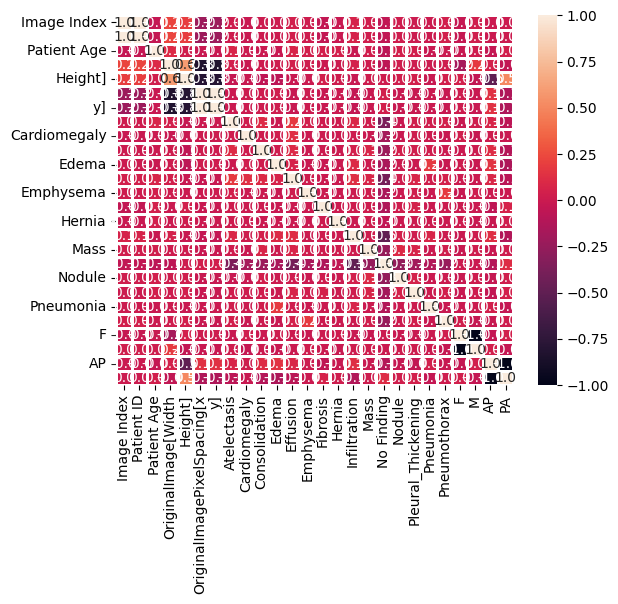

In [42]:
correlation = df_final.corr()
sns.heatmap(correlation, annot = True, fmt=".1f", linewidths=1)



In [130]:
dataset = keras.utils.image_dataset_from_directory('CXR8\CXR8\dataset',batch_size=1,image_size=(1024,1024))

train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

Found 141537 files belonging to 15 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 1024, 1024, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


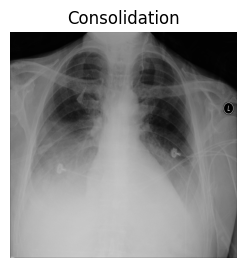

In [131]:
plt.figure(figsize=(10,10))
class_names=['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
print(dataset)
for images, classes in dataset.take(1):
    for i in range(1):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(class_names[int(classes[i])])
        plt.axis("off")

## Create a model with optimizer and init


In [132]:
from keras import layers, Model

# Definir o primeiro modelo usando a API funcional
input_shape = (1024, 1024, 3)
input1 = layers.Input(shape=input_shape)

x1 = layers.Conv2D(32, kernel_size=(3, 3), activation="sigmoid")(input1)
x1 = layers.Conv2D(16, kernel_size=(3, 3), activation="sigmoid")(x1)
x1 = layers.GlobalAveragePooling2D()(x1)
x1 = layers.Flatten()(x1)
x1 = layers.Dense(32, activation="sigmoid")(x1)

# Definir o segundo modelo usando a API funcional
input2 = layers.Input(shape=(20,))

x2 = layers.Dense(32, activation="sigmoid")(input2)
x2 = layers.Dense(16, activation="sigmoid")(x2)
x2 = layers.Dense(32, activation="sigmoid")(x2)
x2 = layers.Flatten()(x2)  # Achatar x2 para tornar compatível com x1

# Concatenar as saídas dos dois modelos
concatenated = layers.concatenate([x1, x2])

# Adicionar a camada de saída
output = layers.Dense(41, activation='sigmoid')(concatenated)
output = layers.Dense(15, activation='sigmoid')(concatenated)

# Criar o modelo final
concat_model = Model(inputs=[input1, input2], outputs=output)

# Resumo do modelo
concat_model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_46      │ (None, 1024,      │          0 │ -                 │
│ (InputLayer)        │ 1024, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 1022,      │        896 │ input_layer_46[0… │
│                     │ 1022, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_47      │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 1020,      │      4,624 │ conv2d_44[0][0]   │
│                     │ 1020, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_111 (Dense)   │ (None, 32)        │        672 │ input_layer_47[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 16)        │          0 │ conv2d_45[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_112 (Dense)   │ (None, 16)        │        528 │ dense_111[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_37          │ (None, 16)        │          0 │ global_average_p… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_113 (Dense)   │ (None, 32)        │        544 │ dense_112[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_110 (Dense)   │ (None, 32)        │        544 │ flatten_37[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_38          │ (None, 32)        │          0 │ dense_113[0][0]   │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_20      │ (None, 64)        │          0 │ dense_110[0][0],  │
│ (Concatenate)       │                   │            │ flatten_38[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_115 (Dense)   │ (None, 15)        │        975 │ concatenate_20[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,783 (34.31 KB)

 Trainable params: 8,783 (34.31 KB)

 Non-trainable params: 0 (0.00 B)

In [133]:
from keras.optimizers import Adam  # Certifique-se de que está importando o otimizador corretamente

concat_model.compile(
    loss=keras.losses.CategoricalCrossentropy(),  # Para rótulos one-hot encoded
    optimizer=Adam(learning_rate=0.01),  # Corrigido aqui
    metrics=['accuracy']
)

##

In [134]:
history = concat_model.fit(
    (train_dataset, df_final),
    epochs=10,  # Ajuste o número de épocas conforme necessário
)

ValueError: Unrecognized data type: x=(<_TakeDataset element_spec=(TensorSpec(shape=(None, 1024, 1024, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>, array([[57, 0, 1, ..., True, False, True],
       [58, 0, 1, ..., True, False, True],
       [58, 0, 1, ..., True, False, True],
       ...,
       [42, 0, 0, ..., False, False, True],
       [29, 0, 0, ..., False, False, True],
       [26, 0, 0, ..., True, False, True]], dtype=object)) (of type <class 'tuple'>)

In [84]:
print(history.history.keys())
print(history.history['accuracy'])
print(history.history['val_accuracy'])
plt.plot(history.history['accuracy'], marker='o', linestyle='-', color='b', label='Linha 1')
plt.plot(history.history['val_accuracy'], marker='s', linestyle='--', color='r', label='Linha 2')
plt.show()

NameError: name 'history' is not defined

In [ ]:
device = torch.cuda.get_device_name(0)
print(f"Nome da placa de vídeo: {device}")
print(f"Versão do CUDA: {torch.version.cuda}")
print(f"Número de GPUs disponíveis: {torch.cuda.device_count()}")